# CBM Model Viewer

Inspect concept head, CBM label head, and (optionally) a black-box classifier. Adjust the paths below to point to your runs.


In [21]:
from pathlib import Path
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 200

# Resolve repo root whether launched from repo/ or analysis/
CWD = Path.cwd()
if (CWD / 'generated').exists():
    REPO_ROOT = CWD
elif (CWD.parent / 'generated').exists():
    REPO_ROOT = CWD.parent
else:
    REPO_ROOT = CWD

# Paths to concept head run and CBM label head
CONCEPT_RUN_DIR = REPO_ROOT / 'outputs' / 'concept_clip_probe_mimic_minfreq25'
CBM_RUN_DIR = REPO_ROOT / 'outputs' / 'cbm_label_head'
BLACKBOX_RUN_DIR = REPO_ROOT / 'outputs' / 'clip_finetune_chexpert5'  # optional

CONCEPT_SCHEMA_PATH = REPO_ROOT / 'generated' / 'concept_bank_sapbert_mimic' / 'concept_schema.json'
print(f'Repo root: {REPO_ROOT}')

Repo root: /home/obadah/code/MedCLIP


## Load artifacts

In [22]:
# Concept head metrics and concept index
concept_metrics = json.loads((CONCEPT_RUN_DIR / 'metrics.json').read_text()) if (CONCEPT_RUN_DIR / 'metrics.json').exists() else None
concept_index = json.loads((CONCEPT_RUN_DIR / 'concept_index.json').read_text()) if (CONCEPT_RUN_DIR / 'concept_index.json').exists() else None
concept_names = [concept_index[str(i)] for i in range(len(concept_index))] if concept_index else []
schema = json.loads(CONCEPT_SCHEMA_PATH.read_text()) if CONCEPT_SCHEMA_PATH.exists() else {}

# CBM metrics
cbm_metrics = json.loads((CBM_RUN_DIR / 'cbm_metrics.json').read_text()) if (CBM_RUN_DIR / 'cbm_metrics.json').exists() else None

# Black-box metrics (optional)
bb_metrics = json.loads((BLACKBOX_RUN_DIR / 'metrics.json').read_text()) if (BLACKBOX_RUN_DIR / 'metrics.json').exists() else None

print('Concept head metrics loaded:', concept_metrics is not None)
print('CBM metrics loaded:', cbm_metrics is not None)
print('Black-box metrics loaded:', bb_metrics is not None)

Concept head metrics loaded: True
CBM metrics loaded: True
Black-box metrics loaded: True


## Concept head training curves

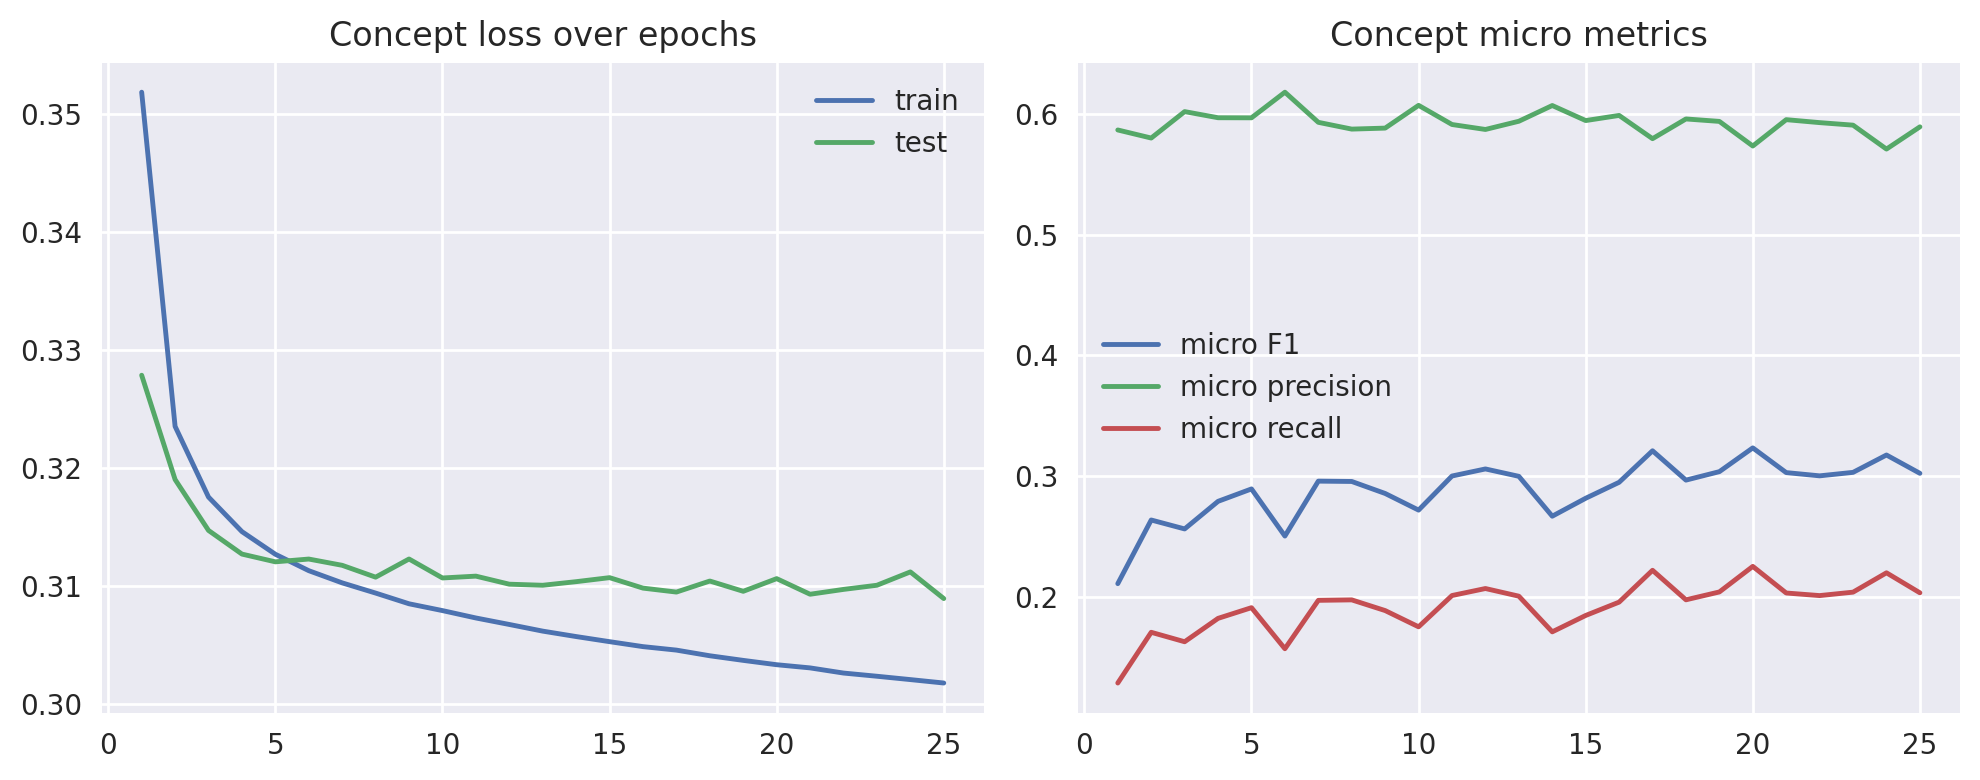

In [23]:
if concept_metrics:
    hist = pd.DataFrame(concept_metrics.get('history', []))
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(hist['epoch'], hist['train_loss'], label='train')
    axes[0].plot(hist['epoch'], hist['test_loss'], label='test')
    axes[0].set_title('Concept loss over epochs')
    axes[0].legend()
    axes[1].plot(hist['epoch'], hist['micro_f1'], label='micro F1')
    axes[1].plot(hist['epoch'], hist['micro_precision'], label='micro precision')
    axes[1].plot(hist['epoch'], hist['micro_recall'], label='micro recall')
    axes[1].set_title('Concept micro metrics')
    axes[1].legend()
    plt.tight_layout()
else:
    print('Concept metrics not found.')

## CBM label-head training curves & summary

,best_micro_f1
0,0.465116


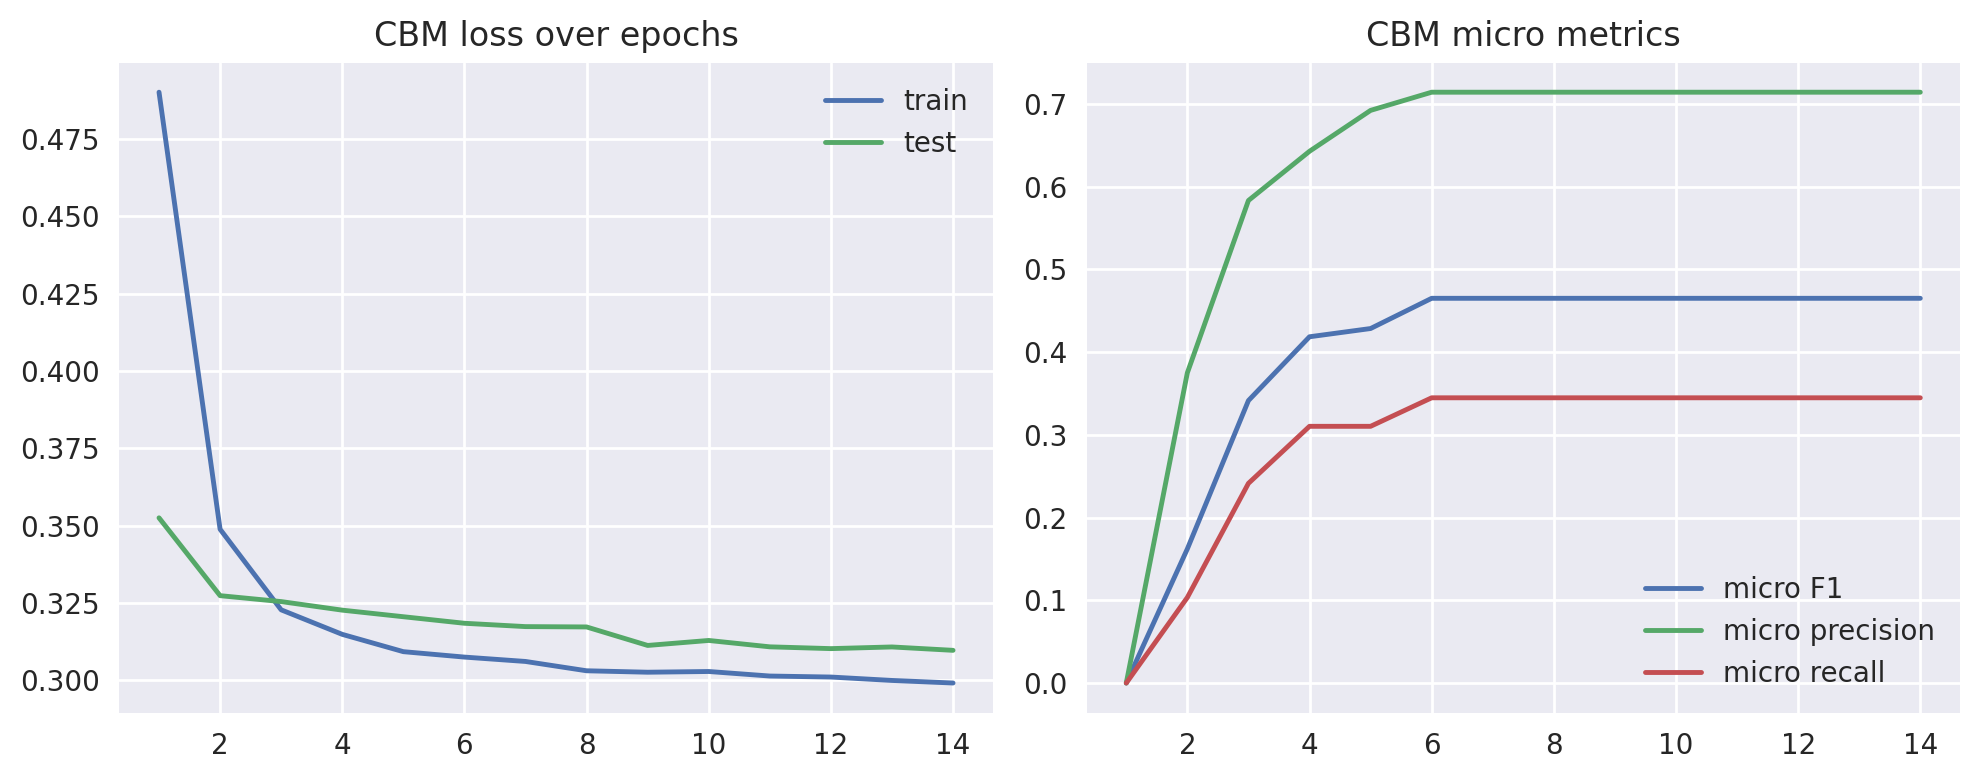

In [24]:
if cbm_metrics:
    cbm_hist = pd.DataFrame(cbm_metrics.get('history', []))
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(cbm_hist['epoch'], cbm_hist['train_loss'], label='train')
    axes[0].plot(cbm_hist['epoch'], cbm_hist['test_loss'], label='test')
    axes[0].set_title('CBM loss over epochs')
    axes[0].legend()
    axes[1].plot(cbm_hist['epoch'], cbm_hist['micro_f1'], label='micro F1')
    if 'micro_precision' in cbm_hist.columns:
        axes[1].plot(cbm_hist['epoch'], cbm_hist['micro_precision'], label='micro precision')
    if 'micro_recall' in cbm_hist.columns:
        axes[1].plot(cbm_hist['epoch'], cbm_hist['micro_recall'], label='micro recall')
    axes[1].set_title('CBM micro metrics')
    axes[1].legend()
    plt.tight_layout()
    summary_keys = ['best_micro_f1','micro_auroc','micro_auprc','macro_auroc','macro_auprc','label_density']
    summary = {k: cbm_metrics.get(k) for k in summary_keys if k in cbm_metrics}
    display(pd.DataFrame([summary]))
else:
    print('CBM metrics not found.')

## Concept→label weights (top contributors)

In [8]:
# Load CBM label head weights and show top concepts per label
cbm_ckpt = None
cbm_head = None
if (CBM_RUN_DIR / 'best_cbm_label_head.pt').exists():
    cbm_ckpt = torch.load(CBM_RUN_DIR / 'best_cbm_label_head.pt', map_location='cpu', weights_only=False)
    state = cbm_ckpt.get('model', cbm_ckpt)
    # Assume the head is a small MLP; take the last linear weights
    for k, v in state.items():
        if k.endswith('2.weight') or k.endswith('3.weight') or k.endswith('weight'):
            weights = v
            break
    else:
        weights = None
    if weights is not None:
        weights_np = weights.cpu().numpy()
        labels = cbm_ckpt.get('args', {}).get('label_columns', []) or []
        for li, label in enumerate(labels):
            w = weights_np[li]
            top_idx = np.argsort(-np.abs(w))[:10]
            rows = []
            for idx in top_idx:
                name = concept_names[idx] if idx < len(concept_names) else str(idx)
                disp = schema.get(name, {}).get('label', name)
                rows.append({'concept': disp, 'weight': w[idx]})
            df = pd.DataFrame(rows)
            print(f"Top concepts for label: {label}")
            display(df)
else:
    print('CBM checkpoint not found; skipping weight inspection.')

Top concepts for label: Enlarged Cardiomediastinum


,concept,weight
0,Structure of pulmonary blood vessel,-0.109155
1,Size,-0.097776
2,stable small,-0.086984
3,Patient condition unchanged,0.086153
4,Atelectasis,-0.085364
5,Heart,0.077885
6,Structure of lower lobe of lung,-0.076030
7,Hilar,0.073715
8,pul,0.073235
9,Right lung,0.072132


Top concepts for label: Cardiomegaly


,concept,weight
0,Oedema - pulmonary,-0.086399
1,Patient condition unchanged,-0.069817
2,Symptom mild,-0.061705
3,Left,-0.057385
4,Abnormal smallness,-0.056934
5,Pleural,0.053182
6,pul,0.053084
7,Mediastinum,-0.047444
8,Pleural,0.046384
9,Right,0.042064


Top concepts for label: Edema


,concept,weight
0,Cardiomegaly,0.387197
1,large effusion,-0.222893
2,Cardiac surface groove,0.197294
3,Structure of right pleural cavity,-0.195224
4,Symptom mild,0.156499
5,pul,-0.154206
6,Dilatation - cardiac,0.149493
7,Cardiovascular material,-0.148955
8,Normal cardiac function,-0.144267
9,more severe,0.138045


Top concepts for label: Consolidation


,concept,weight
0,Hilar,0.214179
1,Cardiac surface groove,0.199184
2,Heart,0.187370
3,Structure of pulmonary blood vessel,0.178096
4,Atrioventricular junction,0.176805
5,Chest clear,0.165689
6,Lung,0.154912
7,Bilateral,0.136840
8,Bony structures,0.112922
9,Normal size cardiac chamber,0.111256


Top concepts for label: Pleural Effusion


,concept,weight
0,Heart,-0.071099
1,Symptom mild,-0.065686
2,Pleural,0.056538
3,large effusion,-0.055260
4,Size,0.050570
5,Cardiomegaly,-0.049586
6,Abnormal smallness,0.048697
7,Right,0.045547
8,Radiologic opacity,0.043714
9,Mediastinum,0.041794


## Black-box summary

In [9]:
if bb_metrics:
    keys = ['best_micro_f1','micro_auroc','micro_auprc','macro_auroc','macro_auprc','label_density','subset_accuracy','multilabel_accuracy','test_loss']
    summary = {k: bb_metrics.get(k) for k in keys if k in bb_metrics}
    display(pd.DataFrame([summary]))
else:
    print('No black-box metrics found (optional).')

,best_micro_f1
0,0.544258


## Example browser (concepts + labels)

Requires a predictions JSONL for concepts and (optionally) CBM label-head predictions if you extend it. Add your own image/report loading if available.

In [20]:
# Minimal example: show top-k concepts for a given study_id from concept predictions
CONCEPT_PRED_PATHS = [
    CONCEPT_RUN_DIR / 'predictions' / 'train_probs.jsonl',
    CONCEPT_RUN_DIR / 'predictions' / 'test_probs.jsonl',
]
STUDY_ID_TO_VIEW = "s56774327"  # fill in a study_id string to inspect

def _norm_sid(s):
    if s is None:
        return ''
    text = str(s)
    digits = ''.join(ch for ch in text if ch.isdigit())
    return digits or text

if STUDY_ID_TO_VIEW:
    target = _norm_sid(STUDY_ID_TO_VIEW)
    rows = None
    for path in CONCEPT_PRED_PATHS:
        if not path.exists():
            continue
        with path.open('r', encoding='utf-8') as handle:
            for line in handle:
                rec = json.loads(line)
                if _norm_sid(rec.get('study_id')) == target:
                    rows = rec['probs']
                    break
        if rows is not None:
            break
    if rows:
        top_idx = np.argsort(rows)[::-1][:10]
        for idx in top_idx:
            name = concept_names[idx] if idx < len(concept_names) else str(idx)
            disp = schema.get(name, {}).get('label', name)
            print('{}: {:.3f}'.format(disp, rows[idx]))
    else:
        print('study_id not found in predictions')
else:
    print('Set STUDY_ID_TO_VIEW to browse concepts for a study.')


Heart: 0.565
pul: 0.559
Cardiomegaly: 0.549
Moderate: 0.483
Lung: 0.462
Symptom mild: 0.395
Patient condition unchanged: 0.359
Pleural: 0.322
Cardiac surface groove: 0.320
Oedema - pulmonary: 0.311
